In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
data_train=pd.read_csv('data_train.txt',index_col=[0],header=0)
data_valid=pd.read_csv('data_valid.txt',index_col=[0],header=0)
data_predict=pd.read_csv('data_predict.txt',index_col=[0],header=0)

In [3]:
#data_train.columns

In [4]:
#补充是否为夜晚（2点到5点）的二元变量
data_train['night']=data_train['time_hour'].apply(lambda x: 1 if (x>1)&(x<6) else 0)
data_valid['night']=data_valid['time_hour'].apply(lambda x: 1 if (x>1)&(x<6) else 0)
data_predict['night']=data_predict['time_hour'].apply(lambda x: 1 if (x>1)&(x<6) else 0)

In [5]:
train_subset=data_train.loc[:,['repost','comments','likes','tfidf','number_in_train','forward_max','comment_max', 'like_max','forward_mean',
       'comment_mean', 'like_mean','time_weekend','panduan','length_all','length_chinese','sharing','book',
       'mention','emoji', 'video','http','title','hotwords', 'keywords','is_noise','stock','night','lottery']]
valid_subset=data_valid.loc[:,['repost','comments','likes','tfidf','number_in_train','forward_max','comment_max', 'like_max','forward_mean',
       'comment_mean', 'like_mean','time_weekend','panduan','length_all','length_chinese','sharing','book',
       'mention','emoji', 'video','http','title','hotwords', 'keywords','is_noise','stock','night','lottery']]

In [6]:
#将互动量为0的数据标记为is_zero
train_subset['is_zero']=0
valid_subset['is_zero']=0
train_subset['is_zero'][(train_subset['comments']+train_subset['repost']+train_subset['likes'])==0]=1
valid_subset['is_zero'][(valid_subset['comments']+valid_subset['repost']+valid_subset['likes'])==0]=1

In [7]:
#valid_subset.tail()

In [8]:
#设置模型的自变量和因变量
y_train=train_subset['is_zero']
x_train=train_subset[['tfidf','number_in_train','forward_max','forward_mean','time_weekend','length_all','sharing','book',
       'mention','emoji', 'video','http','title','hotwords', 'keywords','stock','is_noise','night','lottery']]
x_train=sm.add_constant(x_train)
x_valid=valid_subset[['tfidf','number_in_train','forward_max','forward_mean','time_weekend','length_all','sharing','book',
       'mention','emoji', 'video','http','title','hotwords', 'keywords','stock','is_noise','night','lottery']]
x_valid=sm.add_constant(x_valid)

In [9]:
#拟合logit模型
lr=sm.Logit(y_train,x_train)
result=lr.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.531904
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                is_zero   No. Observations:              1040874
Model:                          Logit   Df Residuals:                  1040854
Method:                           MLE   Df Model:                           19
Date:                Sun, 12 Jan 2020   Pseudo R-squ.:                  0.1810
Time:                        13:29:40   Log-Likelihood:            -5.5365e+05
converged:                       True   LL-Null:                   -6.7599e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3129      0.012     26.403      0.000       0.290       0.336
tfidf         

In [10]:
y_hat=result.predict(x_train)
compare=pd.DataFrame({'predict':y_hat,'actual':train_subset['is_zero']})

In [11]:
#compare[compare['predict']>0.9].describe()

In [12]:
#设置不同的阈值，计算TPR和FPR
criterion=np.arange(0.3,1,0.01)
num=len(criterion)
TPR=np.zeros(num)
FPR=np.zeros(num)
true_index=compare['actual']==1
false_index=compare['actual']==0
for ii in range(num):
    compare['y_hat']=compare['predict']>criterion[ii]
    TPR[ii]=sum(compare['y_hat'][true_index])/sum(true_index)
    FPR[ii]=sum(compare['y_hat'][false_index])/sum(false_index)

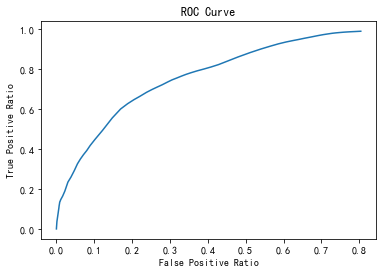

In [13]:
#画出ROC曲线
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(FPR,TPR)
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Ratio')
ax.set_ylabel('True Positive Ratio')
plt.show()
fig.savefig('figure.pdf',bb_inches='tight')


In [14]:
#确认最优的阈值0.67
distance=(1-TPR)**2+FPR**2
optimal_index=np.argmin(distance)
threshold=criterion[optimal_index]
threshold

0.6700000000000004

In [35]:
#根据最优阈值设立logit的判断结果，1为0互动量，0为有互动量数据
data_train['logit']=compare['predict'].apply(lambda x: 1 if x>threshold else 0)
y_hat_valid=result.predict(x_valid)
data_valid['logit']=(y_hat_valid>threshold).astype(int)

In [15]:
data_train['logit']=compare['predict'].apply(lambda x: 1 if x>threshold else 0)
predict_subset=data_predict.loc[:,['tfidf','number_in_train','forward_max','comment_max', 'like_max','forward_mean',
       'comment_mean', 'like_mean','time_weekend','panduan','length_all','length_chinese','sharing','book',
       'mention','emoji', 'video','http','title','hotwords', 'keywords','is_noise','stock','night','lottery']]
x_predict=predict_subset[['tfidf','number_in_train','forward_max','forward_mean','time_weekend','length_all','sharing','book',
       'mention','emoji', 'video','http','title','hotwords', 'keywords','stock','is_noise','night','lottery']]
x_predict=sm.add_constant(x_predict)
y_hat_predict=result.predict(x_predict)
data_predict['logit']=(y_hat_predict>threshold).astype(int)

In [36]:
#data_train['logit'].tail()

In [37]:
#compare['predict'].tail()

In [38]:
#data_valid['logit'].head()

In [39]:
#y_hat_valid

In [40]:
data_train.to_csv('data_train.txt',header=True)
data_valid.to_csv('data_valid.txt',header=True)

In [17]:

data_predict.to_csv('data_predict.txt',header=True)